In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/exchange/train.csv")
val_data = pd.read_csv("../../datasets/exchange/val.csv")
test_data = pd.read_csv("../../datasets/exchange/test.csv")

train_data.index = list(range(train_data.shape[0]))
val_data.index = list(range(train_data.shape[0], train_data.shape[0] + val_data.shape[0]))
test_data.index = list(range(train_data.shape[0] + val_data.shape[0], train_data.shape[0] + val_data.shape[0] + test_data.shape[0]))

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

# Concatenate to get full data
full_data = pd.concat([train_data,val_data,test_data])

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 30
prediction_length = 30

def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 3,
        batch_size = 128,
    )

    return dataloader, dataset

train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)

In [5]:
rnn_hidden = int(0.5*train_data.shape[1])
residual_hidden = int((rnn_hidden + train_data.shape[1])*2)

predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = rnn_hidden,
    residual_layers = 8,
    residual_hidden = residual_hidden,
    dropout = 0,
    scaling = True,
    device = device,
    residual_scaler = True
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 6411


In [6]:
optimizer = torch.optim.Adam(params=predictor.parameters(), lr=1e-3, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.001, total_iters=200)

predictor.train_network(
    train_loader = train_loader,
    epochs=200,
    val_loader = val_loader,
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=200),
    disable_progress_bar = False,
    save_weights = True
)

Epoch: 1/200: 100%|██████████| 48/48 [00:00<00:00, 63.74batch/s, Training loss=1.0094]


val_loss: 0.9886 , 


Epoch: 2/200: 100%|██████████| 48/48 [00:00<00:00, 81.66batch/s, Training loss=0.9357] 


val_loss: 0.8592 , 


Epoch: 3/200: 100%|██████████| 48/48 [00:00<00:00, 82.93batch/s, Training loss=0.7374] 


val_loss: 0.6178 , 


Epoch: 4/200: 100%|██████████| 48/48 [00:00<00:00, 83.64batch/s, Training loss=0.5568] 


val_loss: 0.4976 , 


Epoch: 5/200: 100%|██████████| 48/48 [00:00<00:00, 81.54batch/s, Training loss=0.4483] 


val_loss: 0.4330 , 


Epoch: 6/200: 100%|██████████| 48/48 [00:00<00:00, 81.76batch/s, Training loss=0.4206] 


val_loss: 0.4042 , 


Epoch: 7/200: 100%|██████████| 48/48 [00:00<00:00, 80.19batch/s, Training loss=0.3785] 


val_loss: 0.3490 , 


Epoch: 8/200: 100%|██████████| 48/48 [00:00<00:00, 82.84batch/s, Training loss=0.3368] 


val_loss: 0.3326 , 


Epoch: 9/200: 100%|██████████| 48/48 [00:00<00:00, 83.19batch/s, Training loss=0.3294] 


val_loss: 0.3077 , 


Epoch: 10/200: 100%|██████████| 48/48 [00:00<00:00, 84.56batch/s, Training loss=0.3045] 


val_loss: 0.2999 , 


Epoch: 11/200: 100%|██████████| 48/48 [00:00<00:00, 82.51batch/s, Training loss=0.2778] 


val_loss: 0.2438 , 


Epoch: 12/200: 100%|██████████| 48/48 [00:00<00:00, 83.70batch/s, Training loss=0.2271] 


val_loss: 0.2121 , 


Epoch: 13/200: 100%|██████████| 48/48 [00:00<00:00, 83.77batch/s, Training loss=0.1865] 


val_loss: 0.1525 , 


Epoch: 14/200: 100%|██████████| 48/48 [00:00<00:00, 82.64batch/s, Training loss=0.1465] 


val_loss: 0.1339 , 


Epoch: 15/200: 100%|██████████| 48/48 [00:00<00:00, 83.59batch/s, Training loss=0.1310] 


val_loss: 0.1237 , 


Epoch: 16/200: 100%|██████████| 48/48 [00:00<00:00, 84.73batch/s, Training loss=0.1183] 


val_loss: 0.1132 , 


Epoch: 17/200: 100%|██████████| 48/48 [00:00<00:00, 83.41batch/s, Training loss=0.1059] 


val_loss: 0.1006 , 


Epoch: 18/200: 100%|██████████| 48/48 [00:00<00:00, 85.21batch/s, Training loss=0.0950] 


val_loss: 0.0976 , 


Epoch: 19/200: 100%|██████████| 48/48 [00:00<00:00, 86.44batch/s, Training loss=0.0905] 


val_loss: 0.0818 , 


Epoch: 20/200: 100%|██████████| 48/48 [00:00<00:00, 84.50batch/s, Training loss=0.0862] 


val_loss: 0.0872 , 


Epoch: 21/200: 100%|██████████| 48/48 [00:00<00:00, 85.24batch/s, Training loss=0.0755] 


val_loss: 0.0714 , 


Epoch: 22/200: 100%|██████████| 48/48 [00:00<00:00, 83.06batch/s, Training loss=0.0722] 


val_loss: 0.0733 , 


Epoch: 23/200: 100%|██████████| 48/48 [00:00<00:00, 82.33batch/s, Training loss=0.0738] 


val_loss: 0.0735 , 


Epoch: 24/200: 100%|██████████| 48/48 [00:00<00:00, 82.92batch/s, Training loss=0.0687] 


val_loss: 0.0664 , 


Epoch: 25/200: 100%|██████████| 48/48 [00:00<00:00, 79.61batch/s, Training loss=0.0613] 


val_loss: 0.0652 , 


Epoch: 26/200: 100%|██████████| 48/48 [00:00<00:00, 81.72batch/s, Training loss=0.0608] 


val_loss: 0.0603 , 


Epoch: 27/200: 100%|██████████| 48/48 [00:00<00:00, 83.64batch/s, Training loss=0.0539] 


val_loss: 0.0529 , 


Epoch: 28/200: 100%|██████████| 48/48 [00:00<00:00, 83.30batch/s, Training loss=0.0538] 


val_loss: 0.0485 , 


Epoch: 29/200: 100%|██████████| 48/48 [00:00<00:00, 83.51batch/s, Training loss=0.0479] 


val_loss: 0.0508 , 


Epoch: 30/200: 100%|██████████| 48/48 [00:00<00:00, 83.97batch/s, Training loss=0.0515] 


val_loss: 0.0654 , 


Epoch: 31/200: 100%|██████████| 48/48 [00:00<00:00, 84.60batch/s, Training loss=0.0506] 


val_loss: 0.0527 , 


Epoch: 32/200: 100%|██████████| 48/48 [00:00<00:00, 83.34batch/s, Training loss=0.0512] 


val_loss: 0.0556 , 


Epoch: 33/200: 100%|██████████| 48/48 [00:00<00:00, 83.19batch/s, Training loss=0.0496] 


val_loss: 0.0418 , 


Epoch: 34/200: 100%|██████████| 48/48 [00:00<00:00, 58.04batch/s, Training loss=0.0454]


val_loss: 0.0413 , 


Epoch: 35/200: 100%|██████████| 48/48 [00:00<00:00, 56.67batch/s, Training loss=0.0450]


val_loss: 0.0491 , 


Epoch: 36/200: 100%|██████████| 48/48 [00:00<00:00, 83.98batch/s, Training loss=0.0459] 


val_loss: 0.0563 , 


Epoch: 37/200: 100%|██████████| 48/48 [00:00<00:00, 84.60batch/s, Training loss=0.0437] 


val_loss: 0.0431 , 


Epoch: 38/200: 100%|██████████| 48/48 [00:00<00:00, 84.34batch/s, Training loss=0.0439] 


val_loss: 0.0397 , 


Epoch: 39/200: 100%|██████████| 48/48 [00:00<00:00, 84.94batch/s, Training loss=0.0431] 


val_loss: 0.0395 , 


Epoch: 40/200: 100%|██████████| 48/48 [00:00<00:00, 83.91batch/s, Training loss=0.0455] 


val_loss: 0.0434 , 


Epoch: 41/200: 100%|██████████| 48/48 [00:00<00:00, 84.76batch/s, Training loss=0.0426] 


val_loss: 0.0485 , 


Epoch: 42/200: 100%|██████████| 48/48 [00:00<00:00, 83.02batch/s, Training loss=0.0405] 


val_loss: 0.0367 , 


Epoch: 43/200: 100%|██████████| 48/48 [00:00<00:00, 84.29batch/s, Training loss=0.0404] 


val_loss: 0.0453 , 


Epoch: 44/200: 100%|██████████| 48/48 [00:00<00:00, 84.64batch/s, Training loss=0.0398] 


val_loss: 0.0371 , 


Epoch: 45/200: 100%|██████████| 48/48 [00:00<00:00, 84.32batch/s, Training loss=0.0407] 


val_loss: 0.0352 , 


Epoch: 46/200: 100%|██████████| 48/48 [00:00<00:00, 85.53batch/s, Training loss=0.0409] 


val_loss: 0.0451 , 


Epoch: 47/200: 100%|██████████| 48/48 [00:00<00:00, 85.07batch/s, Training loss=0.0381] 


val_loss: 0.0351 , 


Epoch: 48/200: 100%|██████████| 48/48 [00:00<00:00, 83.63batch/s, Training loss=0.0390] 


val_loss: 0.0351 , 


Epoch: 49/200: 100%|██████████| 48/48 [00:00<00:00, 87.07batch/s, Training loss=0.0371] 


val_loss: 0.0310 , 


Epoch: 50/200: 100%|██████████| 48/48 [00:00<00:00, 85.43batch/s, Training loss=0.0368] 


val_loss: 0.0317 , 


Epoch: 51/200: 100%|██████████| 48/48 [00:00<00:00, 85.76batch/s, Training loss=0.0368] 


val_loss: 0.0266 , 


Epoch: 52/200: 100%|██████████| 48/48 [00:00<00:00, 85.59batch/s, Training loss=0.0333] 


val_loss: 0.0266 , 


Epoch: 53/200: 100%|██████████| 48/48 [00:00<00:00, 84.96batch/s, Training loss=0.0350] 


val_loss: 0.0324 , 


Epoch: 54/200: 100%|██████████| 48/48 [00:00<00:00, 85.33batch/s, Training loss=0.0349] 


val_loss: 0.0346 , 


Epoch: 55/200: 100%|██████████| 48/48 [00:00<00:00, 84.52batch/s, Training loss=0.0360] 


val_loss: 0.0319 , 


Epoch: 56/200: 100%|██████████| 48/48 [00:00<00:00, 86.05batch/s, Training loss=0.0344] 


val_loss: 0.0361 , 


Epoch: 57/200: 100%|██████████| 48/48 [00:00<00:00, 86.49batch/s, Training loss=0.0362] 


val_loss: 0.0403 , 


Epoch: 58/200: 100%|██████████| 48/48 [00:00<00:00, 86.25batch/s, Training loss=0.0348] 


val_loss: 0.0322 , 


Epoch: 59/200: 100%|██████████| 48/48 [00:00<00:00, 87.00batch/s, Training loss=0.0335] 


val_loss: 0.0347 , 


Epoch: 60/200: 100%|██████████| 48/48 [00:00<00:00, 85.50batch/s, Training loss=0.0333] 


val_loss: 0.0349 , 


Epoch: 61/200: 100%|██████████| 48/48 [00:00<00:00, 86.76batch/s, Training loss=0.0331] 


val_loss: 0.0334 , 


Epoch: 62/200: 100%|██████████| 48/48 [00:00<00:00, 84.84batch/s, Training loss=0.0306] 


val_loss: 0.0349 , 


Epoch: 63/200: 100%|██████████| 48/48 [00:00<00:00, 85.25batch/s, Training loss=0.0319] 


val_loss: 0.0240 , 


Epoch: 64/200: 100%|██████████| 48/48 [00:00<00:00, 82.08batch/s, Training loss=0.0313] 


val_loss: 0.0358 , 


Epoch: 65/200: 100%|██████████| 48/48 [00:00<00:00, 85.66batch/s, Training loss=0.0333] 


val_loss: 0.0320 , 


Epoch: 66/200: 100%|██████████| 48/48 [00:00<00:00, 85.37batch/s, Training loss=0.0312] 


val_loss: 0.0296 , 


Epoch: 67/200: 100%|██████████| 48/48 [00:00<00:00, 86.87batch/s, Training loss=0.0335] 


val_loss: 0.0323 , 


Epoch: 68/200: 100%|██████████| 48/48 [00:00<00:00, 86.90batch/s, Training loss=0.0333] 


val_loss: 0.0240 , 


Epoch: 69/200: 100%|██████████| 48/48 [00:00<00:00, 87.01batch/s, Training loss=0.0311] 


val_loss: 0.0266 , 


Epoch: 70/200: 100%|██████████| 48/48 [00:00<00:00, 85.76batch/s, Training loss=0.0321] 


val_loss: 0.0306 , 


Epoch: 71/200: 100%|██████████| 48/48 [00:00<00:00, 86.93batch/s, Training loss=0.0299] 


val_loss: 0.0253 , 


Epoch: 72/200: 100%|██████████| 48/48 [00:00<00:00, 86.12batch/s, Training loss=0.0302] 


val_loss: 0.0233 , 


Epoch: 73/200: 100%|██████████| 48/48 [00:00<00:00, 81.90batch/s, Training loss=0.0325] 


val_loss: 0.0302 , 


Epoch: 74/200: 100%|██████████| 48/48 [00:00<00:00, 85.31batch/s, Training loss=0.0323] 


val_loss: 0.0272 , 


Epoch: 75/200: 100%|██████████| 48/48 [00:00<00:00, 85.76batch/s, Training loss=0.0338] 


val_loss: 0.0369 , 


Epoch: 76/200: 100%|██████████| 48/48 [00:00<00:00, 86.66batch/s, Training loss=0.0337] 


val_loss: 0.0277 , 


Epoch: 77/200: 100%|██████████| 48/48 [00:00<00:00, 84.26batch/s, Training loss=0.0308] 


val_loss: 0.0220 , 


Epoch: 78/200: 100%|██████████| 48/48 [00:00<00:00, 83.34batch/s, Training loss=0.0301] 


val_loss: 0.0249 , 


Epoch: 79/200: 100%|██████████| 48/48 [00:00<00:00, 85.92batch/s, Training loss=0.0285] 


val_loss: 0.0256 , 


Epoch: 80/200: 100%|██████████| 48/48 [00:00<00:00, 86.50batch/s, Training loss=0.0300] 


val_loss: 0.0304 , 


Epoch: 81/200: 100%|██████████| 48/48 [00:00<00:00, 83.17batch/s, Training loss=0.0288] 


val_loss: 0.0296 , 


Epoch: 82/200: 100%|██████████| 48/48 [00:00<00:00, 82.92batch/s, Training loss=0.0329] 


val_loss: 0.0278 , 


Epoch: 83/200: 100%|██████████| 48/48 [00:00<00:00, 77.28batch/s, Training loss=0.0287] 


val_loss: 0.0268 , 


Epoch: 84/200: 100%|██████████| 48/48 [00:00<00:00, 81.18batch/s, Training loss=0.0297] 


val_loss: 0.0246 , 


Epoch: 85/200: 100%|██████████| 48/48 [00:00<00:00, 79.58batch/s, Training loss=0.0277] 


val_loss: 0.0274 , 


Epoch: 86/200: 100%|██████████| 48/48 [00:00<00:00, 81.03batch/s, Training loss=0.0301] 


val_loss: 0.0295 , 


Epoch: 87/200: 100%|██████████| 48/48 [00:00<00:00, 80.05batch/s, Training loss=0.0297] 


val_loss: 0.0224 , 


Epoch: 88/200: 100%|██████████| 48/48 [00:00<00:00, 81.90batch/s, Training loss=0.0280] 


val_loss: 0.0268 , 


Epoch: 89/200: 100%|██████████| 48/48 [00:00<00:00, 80.79batch/s, Training loss=0.0256] 


val_loss: 0.0273 , 


Epoch: 90/200: 100%|██████████| 48/48 [00:00<00:00, 81.45batch/s, Training loss=0.0316] 


val_loss: 0.0279 , 


Epoch: 91/200: 100%|██████████| 48/48 [00:00<00:00, 82.49batch/s, Training loss=0.0308] 


val_loss: 0.0243 , 


Epoch: 92/200: 100%|██████████| 48/48 [00:00<00:00, 81.49batch/s, Training loss=0.0286] 


val_loss: 0.0244 , 


Epoch: 93/200: 100%|██████████| 48/48 [00:00<00:00, 80.57batch/s, Training loss=0.0278] 


val_loss: 0.0222 , 


Epoch: 94/200: 100%|██████████| 48/48 [00:00<00:00, 81.22batch/s, Training loss=0.0279] 


val_loss: 0.0292 , 


Epoch: 95/200: 100%|██████████| 48/48 [00:00<00:00, 81.27batch/s, Training loss=0.0288] 


val_loss: 0.0292 , 


Epoch: 96/200: 100%|██████████| 48/48 [00:00<00:00, 82.94batch/s, Training loss=0.0288] 


val_loss: 0.0288 , 


Epoch: 97/200: 100%|██████████| 48/48 [00:00<00:00, 83.41batch/s, Training loss=0.0273] 


val_loss: 0.0237 , 


Epoch: 98/200: 100%|██████████| 48/48 [00:00<00:00, 84.24batch/s, Training loss=0.0270] 


val_loss: 0.0261 , 


Epoch: 99/200: 100%|██████████| 48/48 [00:00<00:00, 85.19batch/s, Training loss=0.0232] 


val_loss: 0.0234 , 


Epoch: 100/200: 100%|██████████| 48/48 [00:00<00:00, 78.85batch/s, Training loss=0.0303] 


val_loss: 0.0228 , 


Epoch: 101/200: 100%|██████████| 48/48 [00:00<00:00, 84.65batch/s, Training loss=0.0267] 


val_loss: 0.0231 , 


Epoch: 102/200: 100%|██████████| 48/48 [00:00<00:00, 82.01batch/s, Training loss=0.0266] 


val_loss: 0.0218 , 


Epoch: 103/200: 100%|██████████| 48/48 [00:00<00:00, 82.38batch/s, Training loss=0.0263] 


val_loss: 0.0294 , 


Epoch: 104/200: 100%|██████████| 48/48 [00:00<00:00, 82.66batch/s, Training loss=0.0288] 


val_loss: 0.0205 , 


Epoch: 105/200: 100%|██████████| 48/48 [00:00<00:00, 83.60batch/s, Training loss=0.0266] 


val_loss: 0.0246 , 


Epoch: 106/200: 100%|██████████| 48/48 [00:00<00:00, 83.89batch/s, Training loss=0.0249] 


val_loss: 0.0233 , 


Epoch: 107/200: 100%|██████████| 48/48 [00:00<00:00, 84.60batch/s, Training loss=0.0275] 


val_loss: 0.0241 , 


Epoch: 108/200: 100%|██████████| 48/48 [00:00<00:00, 84.79batch/s, Training loss=0.0273] 


val_loss: 0.0234 , 


Epoch: 109/200: 100%|██████████| 48/48 [00:00<00:00, 84.13batch/s, Training loss=0.0275] 


val_loss: 0.0242 , 


Epoch: 110/200: 100%|██████████| 48/48 [00:00<00:00, 84.99batch/s, Training loss=0.0280] 


val_loss: 0.0215 , 


Epoch: 111/200: 100%|██████████| 48/48 [00:00<00:00, 85.14batch/s, Training loss=0.0288] 


val_loss: 0.0233 , 


Epoch: 112/200: 100%|██████████| 48/48 [00:00<00:00, 81.92batch/s, Training loss=0.0234] 


val_loss: 0.0236 , 


Epoch: 113/200: 100%|██████████| 48/48 [00:00<00:00, 81.83batch/s, Training loss=0.0288] 


val_loss: 0.0265 , 


Epoch: 114/200: 100%|██████████| 48/48 [00:00<00:00, 80.03batch/s, Training loss=0.0257] 


val_loss: 0.0240 , 


Epoch: 115/200: 100%|██████████| 48/48 [00:00<00:00, 80.68batch/s, Training loss=0.0257] 


val_loss: 0.0283 , 


Epoch: 116/200: 100%|██████████| 48/48 [00:00<00:00, 79.99batch/s, Training loss=0.0231] 


val_loss: 0.0200 , 


Epoch: 117/200: 100%|██████████| 48/48 [00:00<00:00, 80.98batch/s, Training loss=0.0231] 


val_loss: 0.0284 , 


Epoch: 118/200: 100%|██████████| 48/48 [00:00<00:00, 82.11batch/s, Training loss=0.0289] 


val_loss: 0.0190 , 


Epoch: 119/200: 100%|██████████| 48/48 [00:00<00:00, 83.06batch/s, Training loss=0.0302] 


val_loss: 0.0243 , 


Epoch: 120/200: 100%|██████████| 48/48 [00:00<00:00, 83.76batch/s, Training loss=0.0244] 


val_loss: 0.0183 , 


Epoch: 121/200: 100%|██████████| 48/48 [00:00<00:00, 81.39batch/s, Training loss=0.0256] 


val_loss: 0.0301 , 


Epoch: 122/200: 100%|██████████| 48/48 [00:00<00:00, 83.11batch/s, Training loss=0.0280] 


val_loss: 0.0179 , 


Epoch: 123/200: 100%|██████████| 48/48 [00:00<00:00, 82.82batch/s, Training loss=0.0252] 


val_loss: 0.0204 , 


Epoch: 124/200: 100%|██████████| 48/48 [00:00<00:00, 81.47batch/s, Training loss=0.0281] 


val_loss: 0.0203 , 


Epoch: 125/200: 100%|██████████| 48/48 [00:00<00:00, 83.87batch/s, Training loss=0.0257] 


val_loss: 0.0190 , 


Epoch: 126/200: 100%|██████████| 48/48 [00:00<00:00, 82.42batch/s, Training loss=0.0243] 


val_loss: 0.0210 , 


Epoch: 127/200: 100%|██████████| 48/48 [00:00<00:00, 84.19batch/s, Training loss=0.0244] 


val_loss: 0.0206 , 


Epoch: 128/200: 100%|██████████| 48/48 [00:00<00:00, 83.86batch/s, Training loss=0.0220] 


val_loss: 0.0165 , 


Epoch: 129/200: 100%|██████████| 48/48 [00:00<00:00, 83.62batch/s, Training loss=0.0238] 


val_loss: 0.0254 , 


Epoch: 130/200: 100%|██████████| 48/48 [00:00<00:00, 83.26batch/s, Training loss=0.0237] 


val_loss: 0.0186 , 


Epoch: 131/200: 100%|██████████| 48/48 [00:00<00:00, 83.50batch/s, Training loss=0.0226] 


val_loss: 0.0227 , 


Epoch: 132/200: 100%|██████████| 48/48 [00:00<00:00, 83.53batch/s, Training loss=0.0249] 


val_loss: 0.0202 , 


Epoch: 133/200: 100%|██████████| 48/48 [00:00<00:00, 82.49batch/s, Training loss=0.0234] 


val_loss: 0.0251 , 


Epoch: 134/200: 100%|██████████| 48/48 [00:00<00:00, 84.11batch/s, Training loss=0.0253] 


val_loss: 0.0196 , 


Epoch: 135/200: 100%|██████████| 48/48 [00:00<00:00, 83.83batch/s, Training loss=0.0269] 


val_loss: 0.0206 , 


Epoch: 136/200: 100%|██████████| 48/48 [00:00<00:00, 83.16batch/s, Training loss=0.0252] 


val_loss: 0.0241 , 


Epoch: 137/200: 100%|██████████| 48/48 [00:00<00:00, 84.94batch/s, Training loss=0.0268] 


val_loss: 0.0256 , 


Epoch: 138/200: 100%|██████████| 48/48 [00:00<00:00, 83.35batch/s, Training loss=0.0240] 


val_loss: 0.0186 , 


Epoch: 139/200: 100%|██████████| 48/48 [00:00<00:00, 80.57batch/s, Training loss=0.0255] 


val_loss: 0.0192 , 


Epoch: 140/200: 100%|██████████| 48/48 [00:00<00:00, 81.13batch/s, Training loss=0.0233] 


val_loss: 0.0181 , 


Epoch: 141/200: 100%|██████████| 48/48 [00:00<00:00, 77.17batch/s, Training loss=0.0217] 


val_loss: 0.0170 , 


Epoch: 142/200: 100%|██████████| 48/48 [00:00<00:00, 82.31batch/s, Training loss=0.0231] 


val_loss: 0.0186 , 


Epoch: 143/200: 100%|██████████| 48/48 [00:00<00:00, 80.06batch/s, Training loss=0.0280] 


val_loss: 0.0200 , 


Epoch: 144/200: 100%|██████████| 48/48 [00:00<00:00, 83.28batch/s, Training loss=0.0249] 


val_loss: 0.0189 , 


Epoch: 145/200: 100%|██████████| 48/48 [00:00<00:00, 83.95batch/s, Training loss=0.0225] 


val_loss: 0.0238 , 


Epoch: 146/200: 100%|██████████| 48/48 [00:00<00:00, 82.66batch/s, Training loss=0.0241] 


val_loss: 0.0197 , 


Epoch: 147/200: 100%|██████████| 48/48 [00:00<00:00, 81.94batch/s, Training loss=0.0247] 


val_loss: 0.0230 , 


Epoch: 148/200: 100%|██████████| 48/48 [00:00<00:00, 83.98batch/s, Training loss=0.0245] 


val_loss: 0.0224 , 


Epoch: 149/200: 100%|██████████| 48/48 [00:00<00:00, 81.91batch/s, Training loss=0.0250] 


val_loss: 0.0242 , 


Epoch: 150/200: 100%|██████████| 48/48 [00:00<00:00, 83.83batch/s, Training loss=0.0236] 


val_loss: 0.0239 , 


Epoch: 151/200: 100%|██████████| 48/48 [00:00<00:00, 83.52batch/s, Training loss=0.0251] 


val_loss: 0.0202 , 


Epoch: 152/200: 100%|██████████| 48/48 [00:00<00:00, 80.82batch/s, Training loss=0.0231] 


val_loss: 0.0211 , 


Epoch: 153/200: 100%|██████████| 48/48 [00:00<00:00, 82.77batch/s, Training loss=0.0251] 


val_loss: 0.0182 , 


Epoch: 154/200: 100%|██████████| 48/48 [00:00<00:00, 79.53batch/s, Training loss=0.0237] 


val_loss: 0.0197 , 


Epoch: 155/200: 100%|██████████| 48/48 [00:00<00:00, 83.59batch/s, Training loss=0.0241] 


val_loss: 0.0166 , 


Epoch: 156/200: 100%|██████████| 48/48 [00:00<00:00, 84.75batch/s, Training loss=0.0219] 


val_loss: 0.0258 , 


Epoch: 157/200: 100%|██████████| 48/48 [00:00<00:00, 84.91batch/s, Training loss=0.0229] 


val_loss: 0.0174 , 


Epoch: 158/200: 100%|██████████| 48/48 [00:00<00:00, 85.05batch/s, Training loss=0.0233] 


val_loss: 0.0174 , 


Epoch: 159/200: 100%|██████████| 48/48 [00:00<00:00, 85.24batch/s, Training loss=0.0243] 


val_loss: 0.0179 , 


Epoch: 160/200: 100%|██████████| 48/48 [00:00<00:00, 85.91batch/s, Training loss=0.0220] 


val_loss: 0.0182 , 


Epoch: 161/200: 100%|██████████| 48/48 [00:00<00:00, 85.36batch/s, Training loss=0.0238] 


val_loss: 0.0187 , 


Epoch: 162/200: 100%|██████████| 48/48 [00:00<00:00, 83.94batch/s, Training loss=0.0231] 


val_loss: 0.0189 , 


Epoch: 163/200: 100%|██████████| 48/48 [00:00<00:00, 83.57batch/s, Training loss=0.0204] 


val_loss: 0.0118 , 


Epoch: 164/200: 100%|██████████| 48/48 [00:00<00:00, 83.78batch/s, Training loss=0.0241] 


val_loss: 0.0227 , 


Epoch: 165/200: 100%|██████████| 48/48 [00:00<00:00, 85.87batch/s, Training loss=0.0223] 


val_loss: 0.0274 , 


Epoch: 166/200: 100%|██████████| 48/48 [00:00<00:00, 81.19batch/s, Training loss=0.0232] 


val_loss: 0.0186 , 


Epoch: 167/200: 100%|██████████| 48/48 [00:00<00:00, 83.41batch/s, Training loss=0.0232] 


val_loss: 0.0172 , 


Epoch: 168/200: 100%|██████████| 48/48 [00:00<00:00, 84.95batch/s, Training loss=0.0231] 


val_loss: 0.0191 , 


Epoch: 169/200: 100%|██████████| 48/48 [00:00<00:00, 84.14batch/s, Training loss=0.0246] 


val_loss: 0.0185 , 


Epoch: 170/200: 100%|██████████| 48/48 [00:00<00:00, 83.33batch/s, Training loss=0.0202] 


val_loss: 0.0183 , 


Epoch: 171/200: 100%|██████████| 48/48 [00:00<00:00, 83.54batch/s, Training loss=0.0245] 


val_loss: 0.0196 , 


Epoch: 172/200: 100%|██████████| 48/48 [00:00<00:00, 83.80batch/s, Training loss=0.0228] 


val_loss: 0.0187 , 


Epoch: 173/200: 100%|██████████| 48/48 [00:00<00:00, 84.63batch/s, Training loss=0.0215] 


val_loss: 0.0264 , 


Epoch: 174/200: 100%|██████████| 48/48 [00:00<00:00, 85.49batch/s, Training loss=0.0211] 


val_loss: 0.0161 , 


Epoch: 175/200: 100%|██████████| 48/48 [00:00<00:00, 69.35batch/s, Training loss=0.0245]


val_loss: 0.0208 , 


Epoch: 176/200: 100%|██████████| 48/48 [00:00<00:00, 84.95batch/s, Training loss=0.0237] 


val_loss: 0.0184 , 


Epoch: 177/200: 100%|██████████| 48/48 [00:00<00:00, 85.35batch/s, Training loss=0.0215] 


val_loss: 0.0159 , 


Epoch: 178/200: 100%|██████████| 48/48 [00:00<00:00, 85.76batch/s, Training loss=0.0221] 


val_loss: 0.0176 , 


Epoch: 179/200: 100%|██████████| 48/48 [00:00<00:00, 83.46batch/s, Training loss=0.0217] 


val_loss: 0.0224 , 


Epoch: 180/200: 100%|██████████| 48/48 [00:00<00:00, 85.72batch/s, Training loss=0.0237] 


val_loss: 0.0192 , 


Epoch: 181/200: 100%|██████████| 48/48 [00:00<00:00, 85.71batch/s, Training loss=0.0223] 


val_loss: 0.0233 , 


Epoch: 182/200: 100%|██████████| 48/48 [00:00<00:00, 84.84batch/s, Training loss=0.0215] 


val_loss: 0.0226 , 


Epoch: 183/200: 100%|██████████| 48/48 [00:00<00:00, 84.66batch/s, Training loss=0.0197] 


val_loss: 0.0165 , 


Epoch: 184/200: 100%|██████████| 48/48 [00:00<00:00, 86.10batch/s, Training loss=0.0202] 


val_loss: 0.0130 , 


Epoch: 185/200: 100%|██████████| 48/48 [00:00<00:00, 85.70batch/s, Training loss=0.0197] 


val_loss: 0.0203 , 


Epoch: 186/200: 100%|██████████| 48/48 [00:00<00:00, 86.72batch/s, Training loss=0.0223] 


val_loss: 0.0179 , 


Epoch: 187/200: 100%|██████████| 48/48 [00:00<00:00, 81.70batch/s, Training loss=0.0208] 


val_loss: 0.0116 , 


Epoch: 188/200: 100%|██████████| 48/48 [00:00<00:00, 86.17batch/s, Training loss=0.0202] 


val_loss: 0.0147 , 


Epoch: 189/200: 100%|██████████| 48/48 [00:00<00:00, 83.98batch/s, Training loss=0.0216] 


val_loss: 0.0197 , 


Epoch: 190/200: 100%|██████████| 48/48 [00:00<00:00, 84.66batch/s, Training loss=0.0206] 


val_loss: 0.0251 , 


Epoch: 191/200: 100%|██████████| 48/48 [00:00<00:00, 85.93batch/s, Training loss=0.0219] 


val_loss: 0.0168 , 


Epoch: 192/200: 100%|██████████| 48/48 [00:00<00:00, 85.79batch/s, Training loss=0.0255] 


val_loss: 0.0133 , 


Epoch: 193/200: 100%|██████████| 48/48 [00:00<00:00, 86.89batch/s, Training loss=0.0193] 


val_loss: 0.0145 , 


Epoch: 194/200: 100%|██████████| 48/48 [00:00<00:00, 85.94batch/s, Training loss=0.0245] 


val_loss: 0.0225 , 


Epoch: 195/200: 100%|██████████| 48/48 [00:00<00:00, 84.18batch/s, Training loss=0.0224] 


val_loss: 0.0151 , 


Epoch: 196/200: 100%|██████████| 48/48 [00:00<00:00, 85.14batch/s, Training loss=0.0195] 


val_loss: 0.0214 , 


Epoch: 197/200: 100%|██████████| 48/48 [00:00<00:00, 84.99batch/s, Training loss=0.0207] 


val_loss: 0.0284 , 


Epoch: 198/200: 100%|██████████| 48/48 [00:00<00:00, 83.75batch/s, Training loss=0.0226] 


val_loss: 0.0232 , 


Epoch: 199/200: 100%|██████████| 48/48 [00:00<00:00, 84.98batch/s, Training loss=0.0222] 


val_loss: 0.0208 , 


Epoch: 200/200: 100%|██████████| 48/48 [00:00<00:00, 85.14batch/s, Training loss=0.0195] 


val_loss: 0.0217 , 


In [7]:
# Check performance on validation set
last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < val_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()


realisations = []
for idx in indices:
    realisations.append(
        val_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length,val_dataset.pred_columns].T
    )
realisations = torch.stack(realisations).cpu()


In [8]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=2) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.019640522 MAE: 0.100913405 MDAE: 0.08092928
CRPS_sum: 0.4208093316072509 Variogram_score: 0.019767038916805917


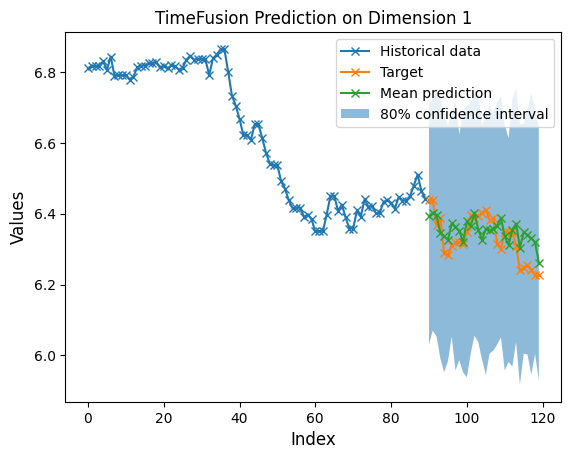

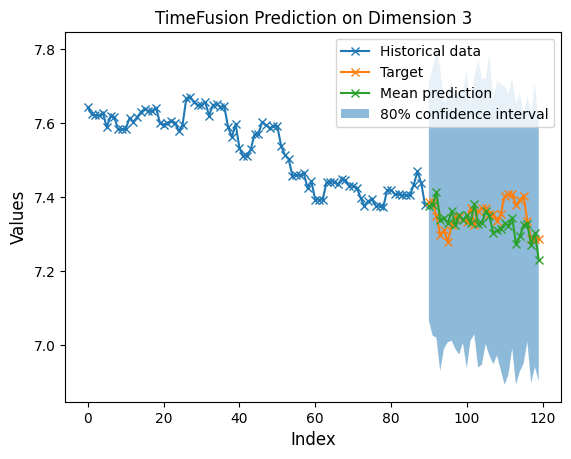

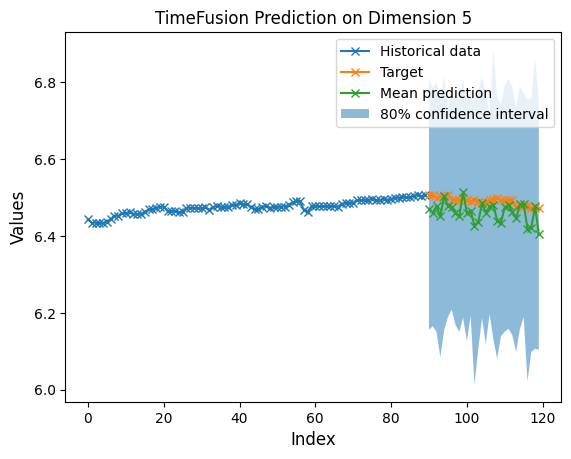

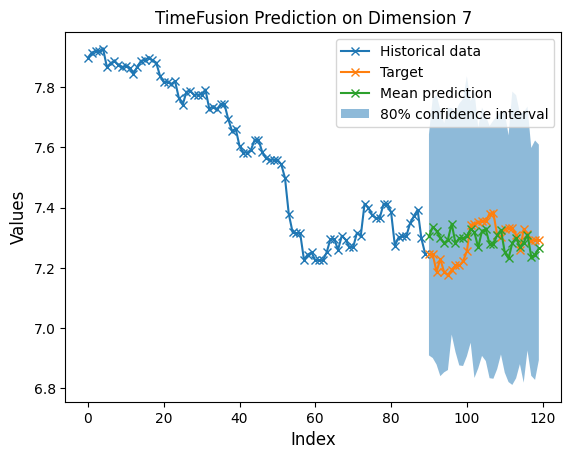

In [18]:
# Sample from model
last_idx = val_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < val_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < val_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < val_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = val_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeFusion Prediction on Dimension {ts}")
    plt.plot(val_dataset.tensor_data[indices[0] - (3*prediction_length - context_length):indices[0] + context_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),val_dataset.tensor_data[indices[0] + context_length:indices[0] + context_length+prediction_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"])
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Values",fontsize=12)
    plt.savefig(f"images/exchange_{ts}.png")


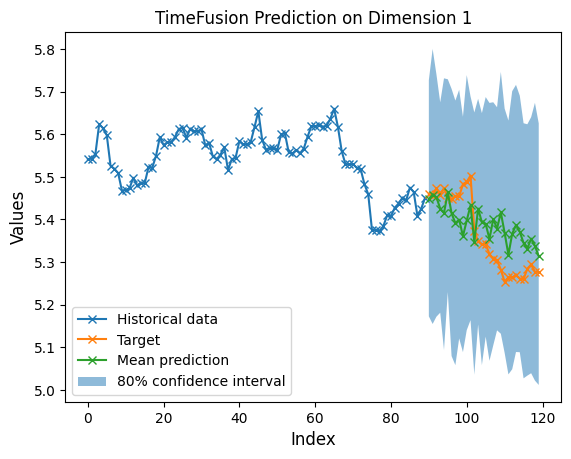

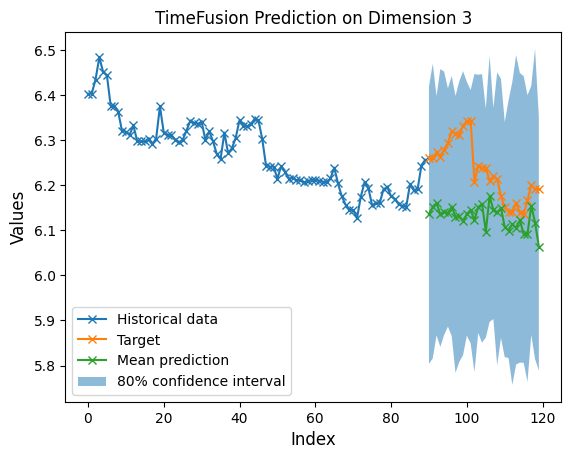

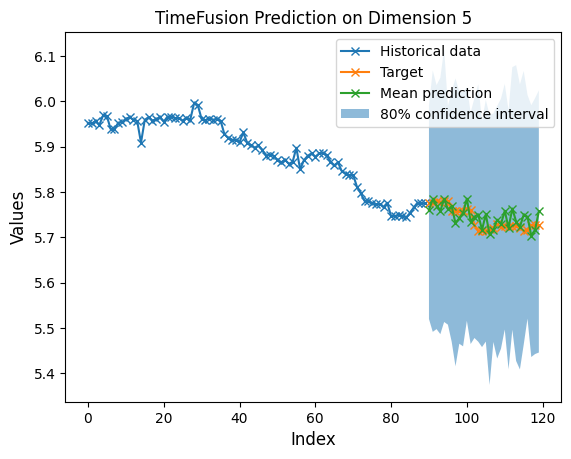

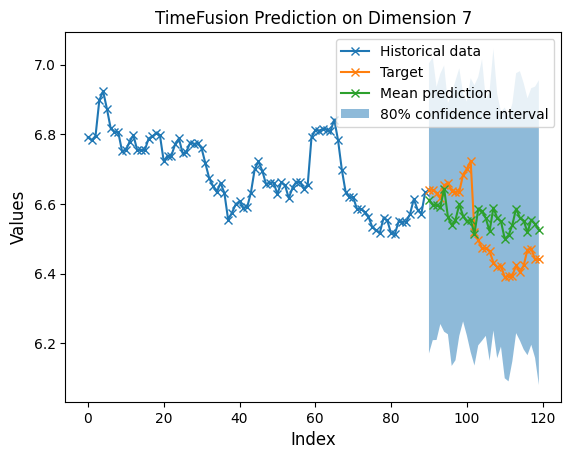

In [19]:
# Sample from model
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeFusion Prediction on Dimension {ts}")
    plt.plot(test_dataset.tensor_data[indices[0] - (3*prediction_length - context_length):indices[0] + context_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),test_dataset.tensor_data[indices[0] + context_length:indices[0] + context_length+prediction_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"])
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Values",fontsize=12)
    plt.savefig(f"images/exchange_{ts}.png")


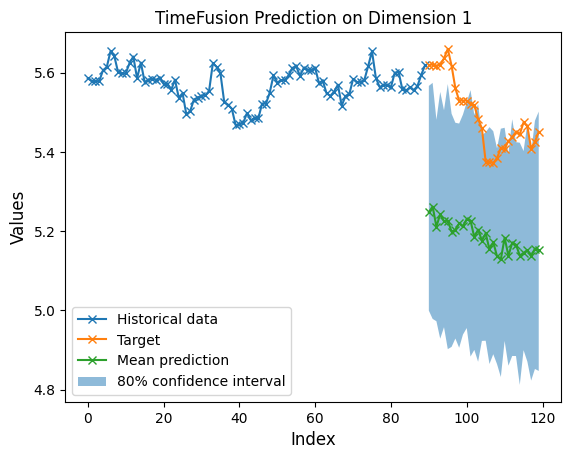

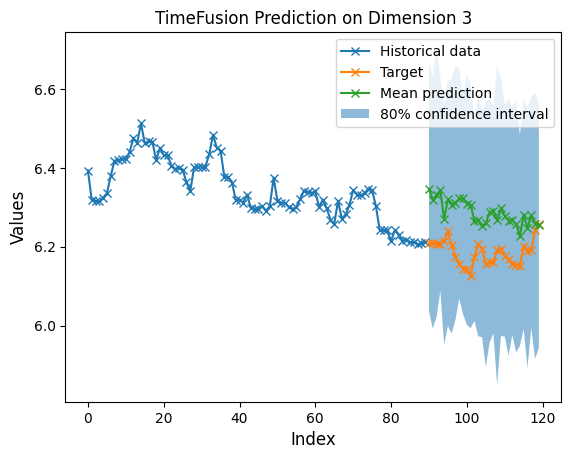

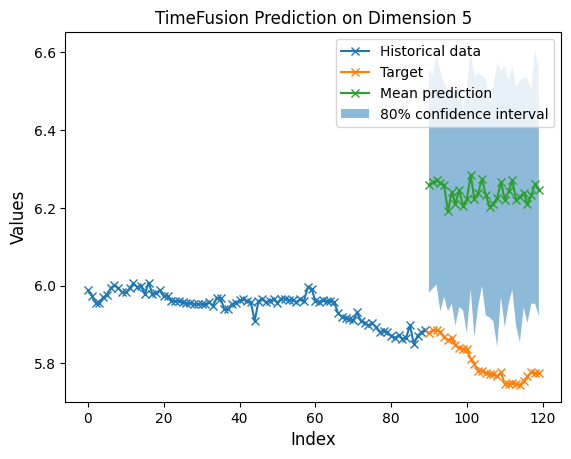

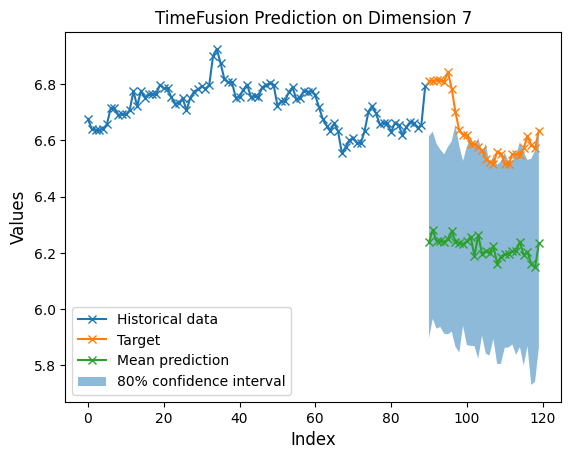

In [10]:
# Sample from model
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = [last_idx - 13*prediction_length]
max_anchors = []
min_anchors = []
for idx in indices:
    off_idx = idx + context_length
    max_values = full_data.loc[full_data.index < test_data.index[off_idx]].max(axis=0)
    min_values = full_data.loc[full_data.index < test_data.index[off_idx]].min(axis=0)
    mean_values = full_data.loc[full_data.index < test_data.index[off_idx]].mean(axis=0)
    max_anchors.append(1.1*torch.tensor(max_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))
    min_anchors.append(1.1*torch.tensor(min_values,dtype=torch.float32,device=device) - 0.1*torch.tensor(mean_values,dtype=torch.float32,device=device))

max_anchors = torch.stack(max_anchors)
min_anchors = torch.stack(min_anchors)
anchors = torch.stack([min_anchors,max_anchors],dim = -1).unsqueeze(2).repeat((1,1,prediction_length,1))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
    anchors=anchors,
    anchor_strength=0.03,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9

for ts in [1,3,5,7]:
    plt.figure()
    plt.title(f"TimeFusion Prediction on Dimension {ts}")
    plt.plot(test_dataset.tensor_data[last_idx - 3*prediction_length:last_idx,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),test_dataset.tensor_data[last_idx:last_idx+prediction_length,ts],"-x")
    plt.plot(list(range(3*prediction_length,4*prediction_length)),torch.mean(samples[0,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(3*prediction_length,4*prediction_length)), samples[0,int(confidence*samples.shape[1]),ts], samples[0,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    plt.legend(["Historical data","Target","Mean prediction","80% confidence interval"])
    plt.xlabel("Index",fontsize=12)
    plt.ylabel("Values",fontsize=12)
    plt.savefig(f"images/exchange_{ts}.png")


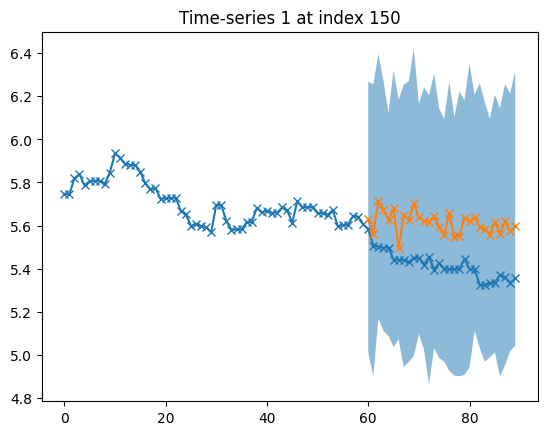

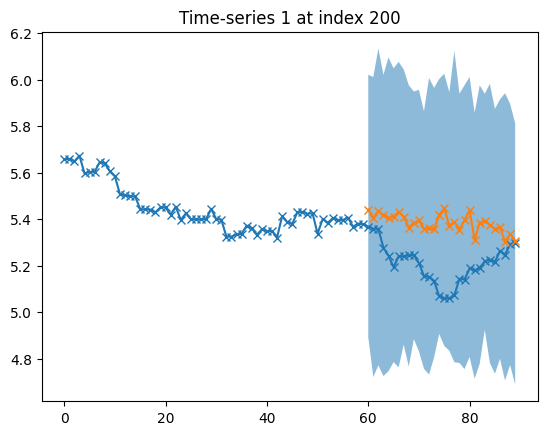

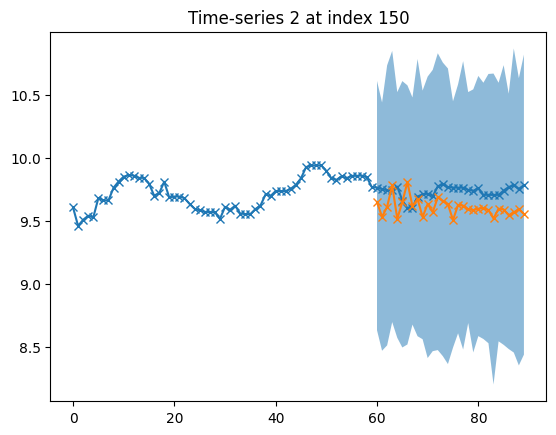

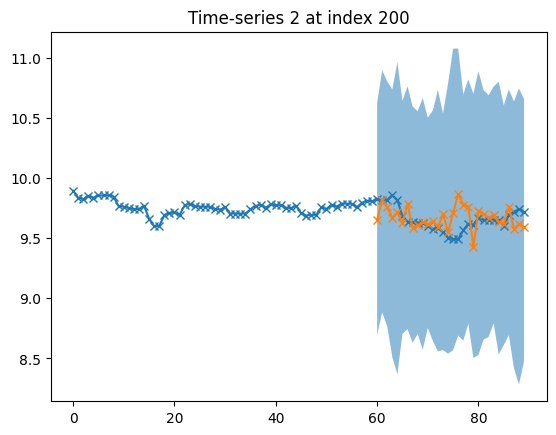

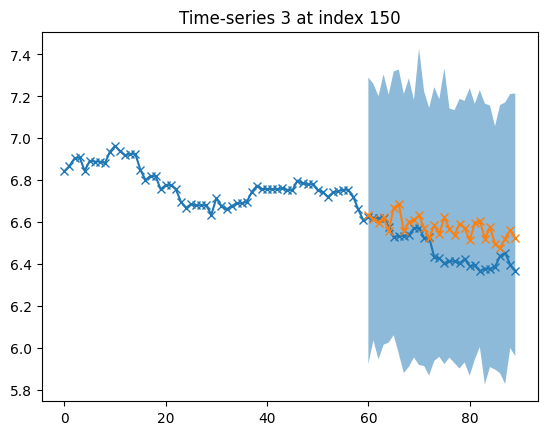

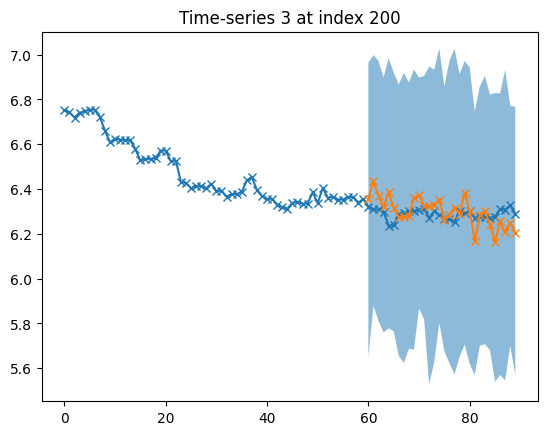

In [21]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([1,2,3],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)

In [23]:
# Make samples and extract realisations for last 14 months of test dataset
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)

realisations = []
for idx in indices:
    realisations.append(
        test_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = torch.stack(realisations).to(samples.device)


In [24]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.042012412 MAE: 0.15260145 MDAE: 0.11435747
CRPS_sum: 0.624789496404784 Variogram_score: 0.04543245967618253
